In [7]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Check what device we're using (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
# This class helps us load images from folders
class InvoiceLetterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = ['invoice', 'letter']  # Our two classes
        self.class_to_idx = {'invoice': 0, 'letter': 1}  # Convert names to numbers
        
        # Lists to store image paths and labels
        self.image_paths = []
        self.labels = []
        
        print(f"Looking for data in: {self.root_dir}")
        
        # Go through each class folder
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            print(f"Checking directory: {class_dir}")
            
            if class_dir.exists():
                # Find all image files
                image_files = []
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']:
                    image_files.extend(list(class_dir.glob(ext)))
                
                print(f"Found {len(image_files)} images in {class_name} folder")
                
                # Add each image to our lists
                for img_path in image_files:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
            else:
                print(f"Warning: Directory {class_dir} does not exist!")
        
        print(f"Total images loaded: {len(self.image_paths)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Load image and convert to RGB
            image = Image.open(img_path).convert('RGB')
            
            # Apply transforms if provided
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a white image if there's an error
            dummy_image = Image.new('RGB', (224, 224), color='white')
            if self.transform:
                dummy_image = self.transform(dummy_image)
            return dummy_image, label

In [9]:
# Transform images for training (with small changes to make model learn better)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize all images to same size
    transforms.RandomHorizontalFlip(p=0.1), # Sometimes flip horizontally
    transforms.RandomRotation(degrees=2),    # Sometimes rotate slightly
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  # Normalize colors
])

# Transform images for testing (no random changes)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("Data transforms created successfully!")

Data transforms created successfully!


In [10]:
# Simple neural network for classifying documents
class DocumentClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DocumentClassifier, self).__init__()
        
        # Feature extraction layers (find patterns in images)
        self.features = nn.Sequential(
            # First block: 3 colors -> 32 features
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second block: 32 -> 64 features
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third block: 64 -> 128 features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Make it smaller for final processing
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classification layers (make final decision)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),                    # Randomly ignore some features
            nn.Linear(128, 64),                 # 128 features -> 64 features
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)          # 64 features -> 2 classes
        )
    
    def forward(self, x):
        x = self.features(x)        # Extract features
        x = torch.flatten(x, 1)     # Flatten for classification
        x = self.classifier(x)      # Make prediction
        return x

# Create the model
model = DocumentClassifier(num_classes=2).to(device)
print("Model created successfully!")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model created successfully!
Model has 101634 parameters


In [11]:
# Function to train the model
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()  # Set to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Function to test the model
def test_model(dataloader, model, loss_fn):
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Don't calculate gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("Training and testing functions created!")

Training and testing functions created!


In [12]:
# Load the dataset
data_dir = "rvl_cdip_subset/images"

try:
    # Create dataset
    full_dataset = InvoiceLetterDataset(data_dir, transform=transform_train)
    
    if len(full_dataset) == 0:
        print("No images found! Please check your data directory.")
    else:
        print(f"Dataset loaded successfully with {len(full_dataset)} images")
        print(f"Classes: {full_dataset.classes}")
        
        # Split into training and testing
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        # Create data loaders
        batch_size = 16
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"Training samples: {len(train_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        # Set up training
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        print("Data loaded and training setup complete!")
        
except Exception as e:
    print(f"Error loading dataset: {e}")

Looking for data in: rvl_cdip_subset\images
Checking directory: rvl_cdip_subset\images\invoice
Found 2477 images in invoice folder
Checking directory: rvl_cdip_subset\images\letter
Found 2464 images in letter folder
Total images loaded: 4941
Dataset loaded successfully with 4941 images
Classes: ['invoice', 'letter']
Training samples: 3952
Test samples: 989
Data loaded and training setup complete!


In [13]:
# Training parameters
num_epochs = 5  # Number of times to go through all data
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    
    # Test the model
    test_loss, test_acc = test_model(test_loader, model, loss_fn)
    
    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

print("\nTraining completed!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

Starting training...

Epoch 1/5
------------------------------
Batch 0, Loss: 0.7015
Batch 10, Loss: 0.8099
Batch 20, Loss: 0.7076
Batch 30, Loss: 0.6960
Batch 40, Loss: 0.7015
Batch 50, Loss: 0.6775
Batch 60, Loss: 0.6650
Batch 70, Loss: 0.7114
Batch 80, Loss: 0.6869
Batch 90, Loss: 0.6563
Batch 100, Loss: 0.7148
Batch 110, Loss: 0.7016
Batch 120, Loss: 0.6664
Batch 130, Loss: 0.6637
Batch 140, Loss: 0.6523
Batch 150, Loss: 0.7285
Batch 160, Loss: 0.6463
Batch 170, Loss: 0.6894
Batch 180, Loss: 0.6815
Batch 190, Loss: 0.6898
Batch 200, Loss: 0.6722
Batch 210, Loss: 0.6426
Batch 220, Loss: 0.7243
Batch 230, Loss: 0.6972
Batch 240, Loss: 0.6676
Train Loss: 0.6904, Train Accuracy: 55.62%
Test Loss: 0.6902, Test Accuracy: 48.43%

Epoch 2/5
------------------------------
Batch 0, Loss: 0.7034
Batch 10, Loss: 0.6775
Batch 20, Loss: 0.6593
Batch 30, Loss: 0.7097
Batch 40, Loss: 0.6429
Batch 50, Loss: 0.5561
Batch 60, Loss: 0.5585
Batch 70, Loss: 0.5892
Batch 80, Loss: 0.6309
Batch 90, Loss: 

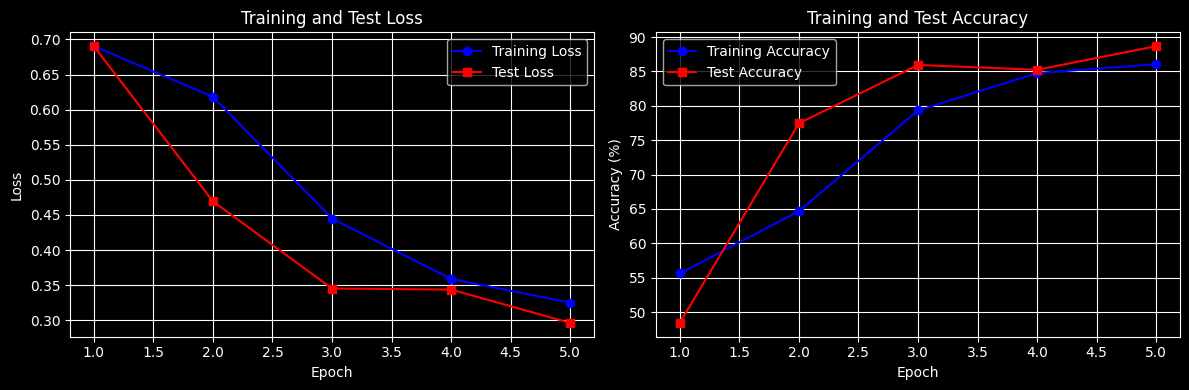


Training Summary:
Best Test Accuracy: 88.68%
Final Test Accuracy: 88.68%


In [14]:
# Plot training results
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, 'r-', label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary
print("\nTraining Summary:")
print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


In [16]:
# Save the trained model
model_path = 'invoice_letter_classifier.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved as '{model_path}'")

# Show model size
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
print(f"Model size: {model_size:.2f} MB")

Model saved as 'invoice_letter_classifier.pth'
Model size: 0.39 MB


In [20]:
# Function to predict a single image
def predict_image(image_path):
    classes = ['invoice', 'letter']
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transform to convert PIL Image to tensor
        image_tensor = transform_test(image)
        
        # Ensure it's a tensor and add batch dimension
        if not isinstance(image_tensor, torch.Tensor):
            # If transform didn't work properly, manually convert
            image_tensor = transforms.ToTensor()(image)
            image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])(image_tensor)
        
        # Add batch dimension and move to device
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            
            # Convert to integer for indexing
            predicted_class = torch.argmax(outputs, dim=1).item()
            predicted_class = int(predicted_class)  # Ensure it's an integer
            
            # Get confidence score
            confidence = probabilities[0][predicted_class].item()
        
        result = classes[predicted_class]
        print(f"Prediction: {result}")
        print(f"Confidence: {confidence:.2f}")
        
        return result, confidence
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

# Example usage (uncomment to test with your image)
# predicted_class, confidence = predict_image("path/to/your/test/image.jpg")